# Robust CSD estimate show case

This is a show case of the robust CSD method

## 1. import packages, load data and define functions for plotting data


In [1]:
# load packages
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import robust_csd                # ===== put the robust_CSD.py in the working directory or add path to it =====

%matplotlib inline

/usr/local/lib/python2.7/site-packages/pkg_resources/__init__.py:1317: UserWarning: /shared/homes/sguan/.cache/Python-Eggs is writable by group/others and vulnerable to attack when used with get_resource_filename. Consider a more secure location (set with .set_extraction_path or the PYTHON_EGG_CACHE environment variable).
  warnings.warn(msg, UserWarning)


In [2]:
# load example LFP data

# ===== put the example_LFP_for_CSD.csv to the location and point path_to_example_data to it  =====
path_to_example_data = './show_case/example_LFP_for_CSD.csv'
LFP = np.loadtxt(path_to_example_data)
ts = np.linspace(-0.1,0.5,num=611)
N, T = LFP.shape
print('the data LFP is of shape {}, which contains {} channels, and {} timestampes'.format(LFP.shape, N, T))

the data LFP is of shape (16, 611), which contains 16 channels, and 611 timestampes


In [3]:
# define functions to plot LFP/CSD

def center2edge(centers):
    # tool function to get edges from centers for plt.pcolormesh
    centers = np.array(centers,dtype='float')
    edges = np.zeros(len(centers)+1)
    if False:     # assumes even spacing
        if len(centers) is 1:
            dx = 1.0
        else:
            dx = centers[-1]-centers[-2]
        edges[0:-1] = centers - dx/2
        edges[-1] = centers[-1]+dx/2
    if True:      # more universal
        if len(centers) is 1:
            dx = 1.0
            edges[0] = centers - dx / 2
            edges[1] = centers + dx / 2
        else:
            edges[1:-1] = (centers[0:-1] + centers[1:])/2.0
            edges[0]  = centers[0]  - (edges[1]- centers[0])
            edges[-1] = centers[-1] + (centers[-1]-edges[-2])
    return edges

def ErpPlot_singlePanel(erp, ts=None, tf_inverse_color=False, cmap='coolwarm', c_lim_style='diverge', trace_scale=1):
    """
    ERP plot in a single panel, where trace and color plot are superimposed. ideal for ERP recorded with linear probe

    :param erp:   erp traces, [N_chan, N_ts]
    :param ts:    timestapes
    :param tf_inverse_color:  if inverse sign for color plot.  Useful for CSD plot since minus "sink" are commonly plot as red
    :return:      None
    """
    N,T = erp.shape
    if ts is None:
        ts= np.arange(T)


    if c_lim_style == 'diverge':
        scale_signal = np.nanmax(np.abs(erp))
        center_signal = 0
        c_min = -scale_signal
        c_max = +scale_signal
    else:
        scale_signal = np.nanmax(erp)-np.nanmin(erp)
        center_signal = np.nanmean(erp)
        c_min = np.nanmin(erp)
        c_max = np.nanmax(erp)


    if tf_inverse_color:
        erp_plot = -erp
    else:
        erp_plot = erp
    plt.pcolormesh(center2edge(ts), center2edge(range(N)), erp_plot, cmap=cmap, vmin=c_min, vmax=c_max)
    plt.plot(ts, ( -(erp-center_signal)/scale_signal/2*trace_scale+np.expand_dims(np.arange(N), axis=1)).transpose(), 'k', alpha=0.2)  # add "-" because we later invert y axis
    ax = plt.gca()
    # ax.set_ylim(sorted(ax.get_ylim(), reverse=True))
    ax.set_ylim([N-0.5, -0.5])

# 2. Plot the Original LFP data

As shown below, we realized that the signal range of two channels (ch 2 and ch 10) are sligthly smaller than in other channels, which may create problems for CSD estimation

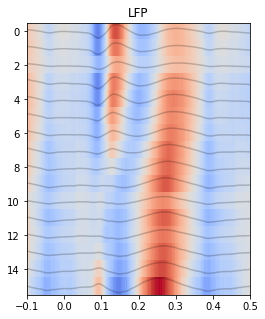

In [4]:
# plot the example LFP data
plt.figure(figsize=(4,5))
ErpPlot_singlePanel(LFP, ts=ts)
plt.title('LFP')

# 3.1 Native CSD estimation

If we estimate CSD natively using the three-point fomula, we got the resutls below.  The checker-borad-like pattern is an artifact caused by the amplification of the the slightly different signal amplitude across channels


/usr/local/lib/python2.7/site-packages/matplotlib/colors.py:494: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


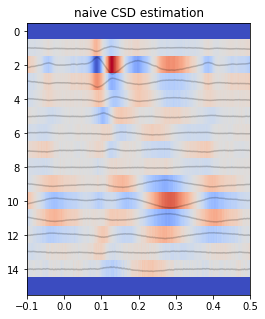

In [5]:
CSD_naive = robust_csd.cal_robust_csd(LFP, lambda_der=0, tf_edge=False)
plt.figure(figsize=(4,5))
ErpPlot_singlePanel(CSD_naive, ts=ts, tf_inverse_color=True)
plt.title('naive CSD estimation')

# 3.2 Robust CSD estimation

To deal with this problem, we assumes that the CSD is continuous/smooth in space; mathematically, we add the squared sum of the 1st order derivatives of CSD (i.e. the 3rd order derivative of LFP) to the cost function to achieve such smoothness.  The other term of the cost function is the deviation of the smoothed LFP from the actural LFP.  the smoothness is controlled by parameter `lambda_der` (the larger, the smoother), and the deviation from original data is controled by `lambda_dev` (the larger, the closer to data)


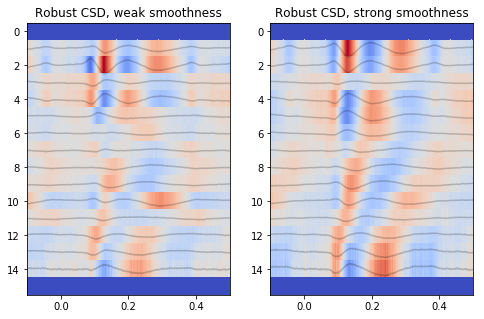

In [9]:
CSD_robust_weak = robust_csd.cal_robust_csd(LFP, lambda_der=0.1, tf_edge=False)
CSD_robust_strong = robust_csd.cal_robust_csd(LFP, lambda_der=1.0, tf_edge=False)

plt.figure(figsize=(8,5))
plt.subplot(121)
ErpPlot_singlePanel(CSD_robust_weak, ts=ts, tf_inverse_color=True)
plt.title('Robust CSD, weak smoothness')

plt.subplot(122)
ErpPlot_singlePanel(CSD_robust_strong, ts=ts, tf_inverse_color=True)
plt.title('Robust CSD, strong smoothness')

# 3.3 Robust CSD estimation, with bad channel removed

We previously noticed that two channels (chan 2 and chan 10) are very different form others and they cause a lot of problems.  We can neglect them for CSD estimation by setting the respective parameter `lambda_dev` to zero (meaning do not consider the deviation of these two channels)

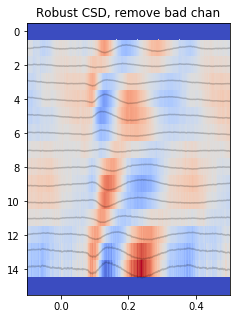

In [7]:
lambda_dev = np.ones(16)
lambda_dev[[2,10]]=0.0   # set two channels to zero
CSD_robust_final = robust_csd.cal_robust_csd(LFP, lambda_dev=lambda_dev, lambda_der=1.0, tf_edge=False)

plt.figure(figsize=(8,5))
plt.subplot(121)
ErpPlot_singlePanel(CSD_robust_final, ts=ts, tf_inverse_color=True)
plt.title('Robust CSD, remove bad chan')

# 4. Summary

Put them together

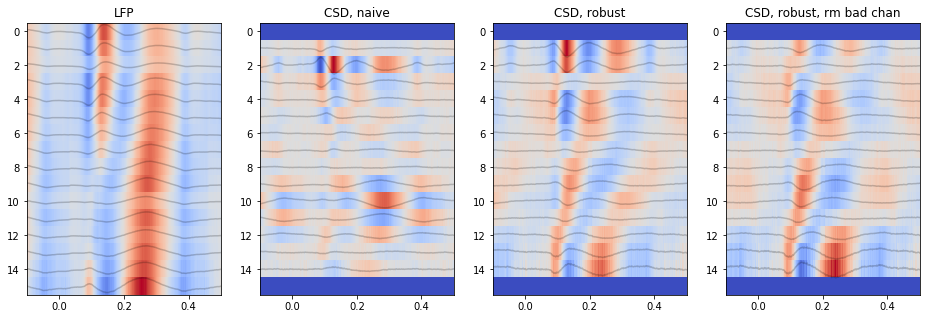

In [8]:
plt.figure(figsize=(16,5))
plt.subplot(141)
ErpPlot_singlePanel(LFP, ts=ts, tf_inverse_color=False)
plt.title('LFP')
plt.subplot(142)
ErpPlot_singlePanel(CSD_naive, ts=ts, tf_inverse_color=True)
plt.title('CSD, naive')
plt.subplot(143)
ErpPlot_singlePanel(CSD_robust_strong, ts=ts, tf_inverse_color=True)
plt.title('CSD, robust')
plt.subplot(144)
ErpPlot_singlePanel(CSD_robust_final, ts=ts, tf_inverse_color=True)
plt.title('CSD, robust, rm bad chan')